<a href="https://colab.research.google.com/github/not-sid-29/ocr_mnist_detect/blob/main/OCR_customCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Character Recognition using Convolutional Neural Networks:

In [ ]:
# Setups and Imports
!pip install --q torch
!pip install --q torchvision
!pip install --q fastai
!pip install --q timm
!pip install --q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
##Loading up the MNIST dataset:
from fastai.vision.all import *
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

#Check if data is loaded correctly:
path.ls()

(#2) [Path('training'),Path('testing')]

<Axes: >

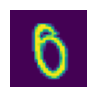

In [ ]:
example = Image.open(path/'training'/'0'/'26338.png')
show_image(example)

In [ ]:
from fastcore.parallel import *

#Set training path:
train_path = path/'training'
files = get_image_files(train_path)
print("Training size: ", len(files))

#Checking the sizes of all available images:
def return_size(image):
  return PILImage.create(image).size

sizes = parallel(return_size, files, n_workers=4)
print("Image sizes: \n")
pd.Series(sizes).value_counts()



Training size:  60000
Image sizes: 



,count
"(28, 28)",60000


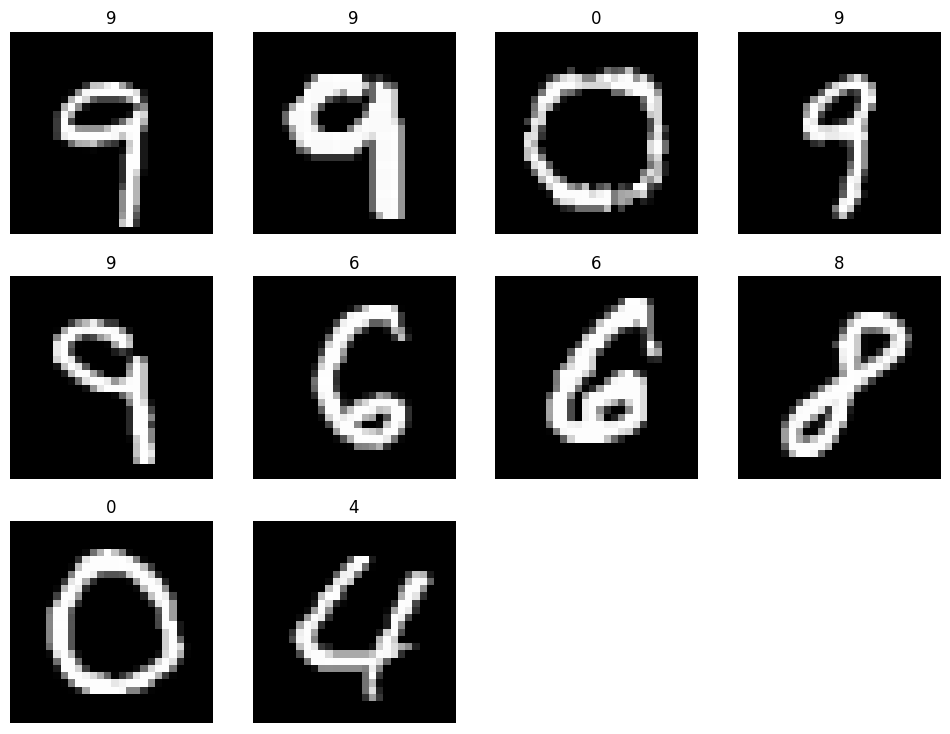

In [ ]:
#Creating suitable dataloaders:
mnist_dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.3,
    seed=300,
    item_tfms=Resize(28, method='pad'),
    batch_tfms=Normalize()
)

mnist_dls.show_batch(max_n=10)

### Approach-1: Using a Pretrained model.

- here the pretrained model that has been used is `convnext_tiny` model.
- It will be finetuned to the MNIST dataset.

In [ ]:
#Creating a convnext learner object:
model = "convnext_tiny"
convnext_learn = vision_learner(
    dls=mnist_dls,
    arch=model,
    metrics=accuracy,
    path='.'
).to_fp16()


#Finding optimal values of learning rate:
convnext_learn.lr_find(suggest_funcs=(slide, valley))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (2 x 2). Kernel size can't be greater than actual input size

In [ ]:
convnext_learn.fine_tune(epochs=10, base_lr=0.0025)

epoch,train_loss,valid_loss,accuracy,time
0,0.625256,0.328104,0.896278,02:16


epoch,train_loss,valid_loss,accuracy,time
0,0.292157,0.086384,0.972889,02:38
1,0.194301,0.083986,0.974944,02:39
2,0.193345,0.072287,0.978611,02:48
3,0.173813,0.127458,0.966167,02:39
4,0.141997,0.053034,0.984000,02:41
5,0.091371,0.045188,0.986111,02:39
6,0.101782,0.045085,0.987722,02:39
7,0.095637,0.033005,0.989833,02:38
8,0.060821,0.031325,0.990278,02:40
9,0.077355,0.033965,0.989778,02:38


In [ ]:
convnext_learn.export("mnist_finetuned_convnext.pkl")

---

### Approach-2: Training a custom CNN on MNIST dataset:

In [ ]:
#Defining the convolutional layer:

def conv_2d(n_inputs, n_final, ks=2, activation=True):
  '''
  Function that generates a 2D-Convolutional Layer based on the parameters passed.
  ---
  Arguments:
  n_inputs : input channels,
  n_final : Output channels,
  ks : Kernel Size,
  activation : Whether activation is necessary or not.
  '''

  layer = [nn.Conv2d(
      in_channels=n_inputs,
      out_channels=n_final,
      kernel_size=ks,
      stride=2,
      padding=ks//2
  )]
  if activation:
    layer.append(nn.ReLU())
  layer.append(nn.BatchNorm2d(n_final))
  return nn.Sequential(*layer)

In [ ]:
def mnist_network():

 return sequential(
    conv_2d(1, 32, ks=6),          # Input: 1 channel (grayscale), Output: 32 channels
    nn.MaxPool2d(2),         # Reduce spatial dimensions by half
    conv_2d(32, 64),         # Input: 32 channels, Output: 64 channels
    nn.MaxPool2d(2),         # Reduce spatial dimensions by half
    conv_2d(64, 128),        # Input: 64 channels, Output: 128 channels
    nn.MaxPool2d(2),         # Reduce spatial dimensions by half
    conv_2d(128, 256),       # Add an additional layer for more feature extraction
    nn.Dropout(0.5),
    conv_2d(256, 10, activation=False),      # Output layer for 10 classes (0-9 digits)
    Flatten()
    )


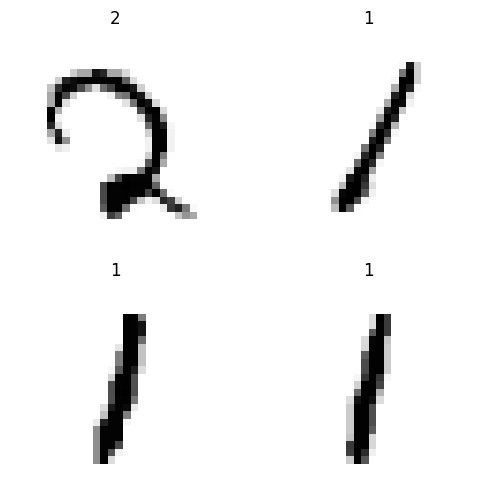

In [ ]:
#Designing custom-dataloaders:
mnist_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=20),
    get_y=parent_label,
    item_tfms=Resize(28, method='pad'),
    batch_tfms=Normalize()
)

mnist_bw_dls = mnist_block.dataloaders(train_path, bs=128)
mnist_bw_dls.show_batch(max_n=4)

In [ ]:
#Training the custom model:

def train_one_cycle(epoch=5, lr=0.0025):
  custom_learner = Learner(
      mnist_bw_dls,
      mnist_network(),
      loss_func=F.cross_entropy,
      metrics=accuracy
  )
  custom_learner.fit_one_cycle(epoch, lr)
  return custom_learner



print("_________________________")
print("Model Training Started: \n")
train = train_one_cycle(epoch=8, lr=0.025)
train.export("mnistnet.pkl")

_________________________
Model Training Started: 



epoch,train_loss,valid_loss,accuracy,time
0,0.192984,0.110020,0.970250,01:30
1,0.113247,0.072471,0.978750,01:29
2,0.092555,0.060656,0.981500,01:28
3,0.064524,0.054641,0.984667,01:27
4,0.044062,0.040612,0.987250,01:28
5,0.028722,0.036111,0.990917,01:29
6,0.020193,0.030967,0.991250,01:29
7,0.010311,0.030382,0.991583,01:26


SuggestedLRs(slide=0.03981071710586548, valley=0.0030199517495930195)

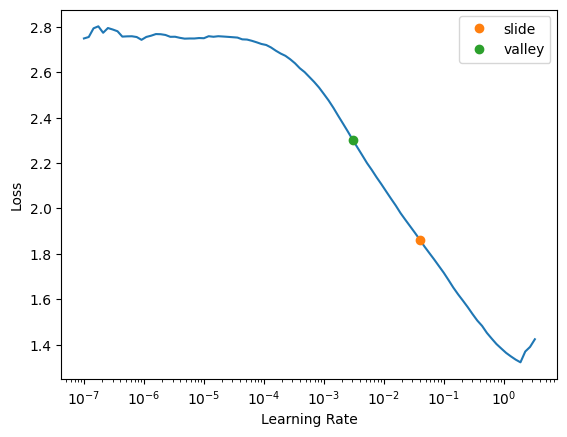

In [ ]:
custom_learner = Learner(
      mnist_bw_dls,
      mnist_network(),
      loss_func=F.cross_entropy,
      metrics=accuracy)
custom_learner.lr_find(suggest_funcs=(slide, valley))

In [ ]:
.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 15 x 15  
Conv2d                                    1184       True      
ReLU                                                           
BatchNorm2d                               64         True      
____________________________________________________________________________
                     128 x 32 x 7 x 7    
MaxPool2d                                                      
____________________________________________________________________________
                     128 x 64 x 4 x 4    
Conv2d                                    8256       True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     128 x 64 x 2 x 2    
MaxPool2d                                    